## Deepchecks machine learning pipeline

### By:
[Jose R. Zapata](https://joserzapata.github.io/)

### Date:
2025-05-12

### Description:

Deepchecks is a Python library that provides a suite of tools for validating and testing machine learning models. It helps ensure that your models are robust, reliable, and perform as expected in production environments.
This notebook demonstrates how to use Deepchecks to validate a machine learning pipeline. 

<https://github.com/JoseRZapata/demo-data-science-template/blob/main/notebooks/5-models/02-jrz-basic_algorithms_model_selection-2024_11_02.ipynb>

## 📚 Import  libraries

In [1]:
# base libraries for data science
from pathlib import Path


import pandas as pd
from joblib import dump

from deepchecks.tabular.suites import train_test_validation
from deepchecks.tabular import Dataset
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## 💾 Load data

In [2]:
url_data = "https://www.openml.org/data/get_csv/16826755/phpMYEkMl"
dataset = pd.read_csv(url_data, low_memory=False, na_values="?")

## 👷 Data preparation

The columns that will be used are:

['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']


In [3]:
selected_features = [
    "pclass",
    "sex",
    "age",
    "sibsp",
    "parch",
    "fare",
    "embarked",
    "survived",
]

dataset_features = dataset[selected_features]

## Convert data types

In [4]:
# numerical columns
cols_numeric_float = ["age", "fare"]
cols_numeric_int = ["sibsp", "parch"]
cols_numeric = cols_numeric_float + cols_numeric_int

# categorical columns
cols_categoric = ["sex", "embarked"]
cols_categoric_ord = ["pclass"]
cols_categorical = cols_categoric + cols_categoric_ord

### Categorical variables

In [5]:
dataset[cols_categoric] = dataset[cols_categoric].astype("category")

In [6]:
dataset["pclass"] = pd.Categorical(
    dataset["pclass"], categories=[3, 2, 1], ordered=True
)

### Numerical variables

In [7]:
dataset[cols_numeric_float] = dataset[cols_numeric_float].astype("float")
dataset[cols_numeric_int] = dataset[cols_numeric_int].astype("int8")

### target variables

In [8]:
target = "survived"

dataset[target] = dataset[target].astype("int8")

drop duplicates if any exist in the dataset, is important to avoid any bias in the dataset or data leakage when a machine learning model is trained on the data.

Duplicated values creates bias in the dataset, and the model will be trained on the same data, which will lead to overfitting, and data leakage problems.

In [9]:
dataset = dataset.drop_duplicates()

## Data Integrity Validation

Status,Check,Condition,More Info
!,String Mismatch,No string variants,"Found 1 out of 7 columns with amount of variants above threshold: {'home.dest': ['swedenworcesterma', 'londonnewyorkny', 'parisfrancenewyorkny']}"
✓,Mixed Nulls,Number of different null types is less or equal to 1,Passed for 14 relevant columns
✓,Mixed Data Types,Rare data types in column are either more than 10% or less than 1% of the data,"14 columns passed: found 2 columns with negligible types mix, and 12 columns without any types mix"
✓,Feature Label Correlation,Features' Predictive Power Score is less than 0.8,Passed for 13 relevant columns
✓,Feature-Feature Correlation,Not more than 0 pairs are correlated above 0.9,All correlations are less than 0.9 except pairs []
✓,Single Value in Column,Does not contain only a single value,Passed for 14 relevant columns
✓,Special Characters,Ratio of samples containing solely special character is less or equal to 0.1%,Passed for 14 relevant columns
✓,Data Duplicates,Duplicate data ratio is less or equal to 5%,Found 0% duplicate data
✓,String Length Out Of Bounds,Ratio of string length outliers is less or equal to 0%,Passed for 5 relevant columns
✓,Conflicting Labels,Ambiguous sample ratio is less or equal to 0%,Ratio of samples with conflicting labels: 0%


Status,Condition,More Info
!,No string variants,"Found 1 out of 7 columns with amount of variants above threshold: {'home.dest': ['swedenworcesterma', 'londonnewyorkny', 'parisfrancenewyorkny']}"


Status,Condition,More Info
✓,Number of different null types is less or equal to 1,Passed for 14 relevant columns


,,Count,Percent of data
Column Name,Value,,
age,math.nan,263,20.09%
fare,math.nan,1,0.08%
cabin,numpy.nan,1014,77.46%
embarked,numpy.nan,2,0.15%
boat,numpy.nan,823,62.87%
body,math.nan,1188,90.76%
home.dest,numpy.nan,564,43.09%


Status,Condition,More Info
✓,Rare data types in column are either more than 10% or less than 1% of the data,"14 columns passed: found 2 columns with negligible types mix, and 12 columns without any types mix"


,ticket,boat
Strings,26.89%,18.11%
Numbers,73.11%,81.89%
Strings examples,"['A/5 1478', 'STON/O 2. 31012...', 'STON/O 2. 31012...']","['B', 'D', 'C']"
Numbers examples,"[2,653, 370,374, 349,235]","[5, 13, 9]"


Status,Condition,More Info
✓,Features' Predictive Power Score is less than 0.8,Passed for 13 relevant columns


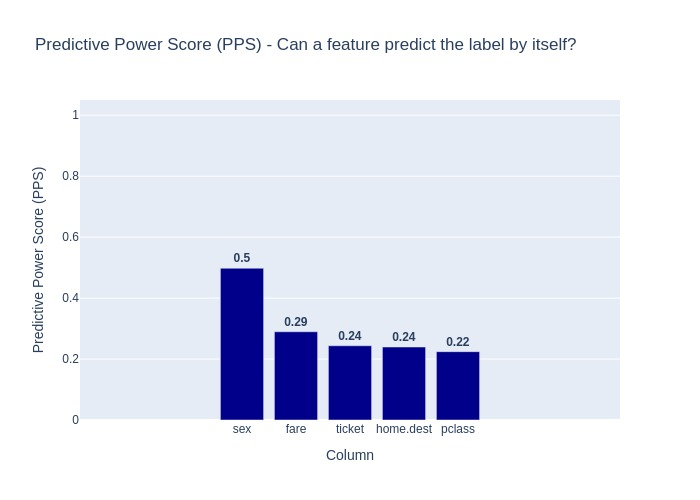

Status,Condition,More Info
✓,Not more than 0 pairs are correlated above 0.9,All correlations are less than 0.9 except pairs []


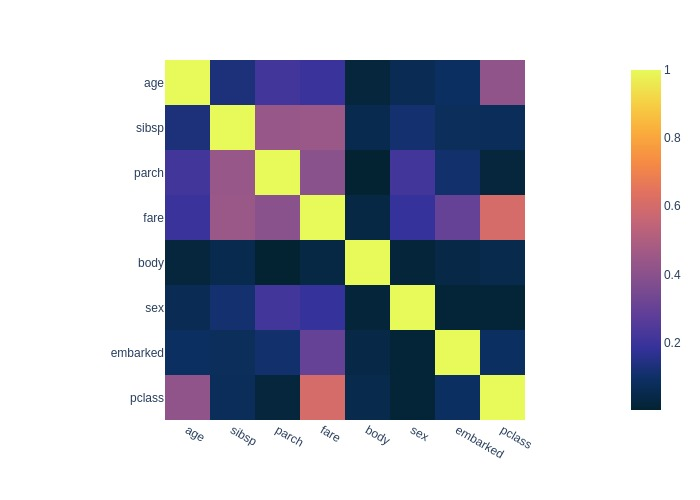

,Outlier Probability Score,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
720,1.00,3,0,"Colbert, Mr. Patrick",male,24.00,0,0,371109,7.25,nan,Q,nan,nan,"Co Limerick, Ireland Sherbrooke, PQ"
971,0.99,3,0,"Linehan, Mr. Michael",male,nan,0,0,330971,7.88,nan,Q,nan,nan,nan
803,0.96,3,0,"Foley, Mr. Joseph",male,26.00,0,0,330910,7.88,nan,Q,nan,nan,"Ireland Chicago, IL"
1193,0.95,3,0,"Scanlan, Mr. James",male,nan,0,0,36209,7.72,nan,Q,nan,nan,nan
1167,0.95,3,0,"Sadlier, Mr. Matthew",male,nan,0,0,367655,7.73,nan,Q,nan,nan,nan


Check,Reason
Identifier Label Correlation - Train Dataset,DatasetValidationError: Dataset does not contain an index or a datetime. see Dataset docs
Single Value in Column,Nothing found
Special Characters,Nothing found
Data Duplicates,Nothing found
String Length Out Of Bounds,Nothing found
Conflicting Labels,Nothing found


In [10]:
from deepchecks.tabular.suites import data_integrity

ds = Dataset(dataset, cat_features=cols_categorical, label=target)


# Run Suite:
integ_suite = data_integrity()
suite_result = integ_suite.run(ds)
# Note: the result can be saved as html using suite_result.save_as_html()
# or exported to json using suite_result.to_json()
suite_result.show_not_interactive()

## 👨‍🏭 Feature Engineering

In [11]:
numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

categorical_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OrdinalEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, cols_numeric),
        ("categoric", categorical_pipe, cols_categoric),
        ("categoric ordinal", categorical_ord_pipe, cols_categoric_ord),
    ]
)

## Train / Test split

In [12]:
# split data into features and target

X_features = dataset.drop(target, axis="columns")
Y_target = dataset[target]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, stratify=Y_target, test_size=0.2, random_state=42
)

## Train / Test Validation

In [13]:
from deepchecks.tabular.suites import train_test_validation

In [14]:
train_ds = Dataset(
    pd.concat([x_train, y_train], axis="columns"),
    label=target,
    cat_features=cols_categorical,
    set_index_from_dataframe_index=True,
)
test_ds = Dataset(
    pd.concat([x_test, y_test], axis="columns"),
    label=target,
    cat_features=cols_categorical,
    set_index_from_dataframe_index=True,
)


Status,Check,Condition,More Info
✖,Feature Label Correlation Change,Train-Test features' Predictive Power Score difference is less than 0.2,"Found 3 out of 13 features with PPS difference above threshold: {'boat': '0.66', 'cabin': '0.21', 'ticket': '0.26'}"
✖,Feature Drift,categorical drift score < 0.2 and numerical drift score < 0.2,Failed for 1 out of 8 columns. Found 1 numeric columns with Kolmogorov-Smirnov above threshold: {'body': '0.26'}
✓,Feature Label Correlation Change,Train features' Predictive Power Score is less than 0.7,Passed for 13 relevant columns
✓,Datasets Size Comparison,Test-Train size ratio is greater than 0.01,Test-Train size ratio is 0.25
✓,New Category Train Test,Ratio of samples with a new category is less or equal to 0%,Passed for 3 relevant features
✓,Label Drift,Label drift score < 0.15,Label's drift score Cramer's V is 0
✓,Multivariate Drift,Drift value is less than 0.25,"Found drift value of: 0.09, corresponding to a domain classifier AUC of: 0.55"
✓,New Label Train Test,Number of new label values is less or equal to 0,Found 0 new labels in test data: []
✓,String Mismatch Comparison,No new variants allowed in test data,Passed for 7 relevant columns
✓,Index Train-Test Leakage,Ratio of leaking indices is less or equal to 0%,No index leakage found


Status,Condition,More Info
✖,Train-Test features' Predictive Power Score difference is less than 0.2,"Found 3 out of 13 features with PPS difference above threshold: {'boat': '0.66', 'cabin': '0.21', 'ticket': '0.26'}"
✓,Train features' Predictive Power Score is less than 0.7,Passed for 13 relevant columns


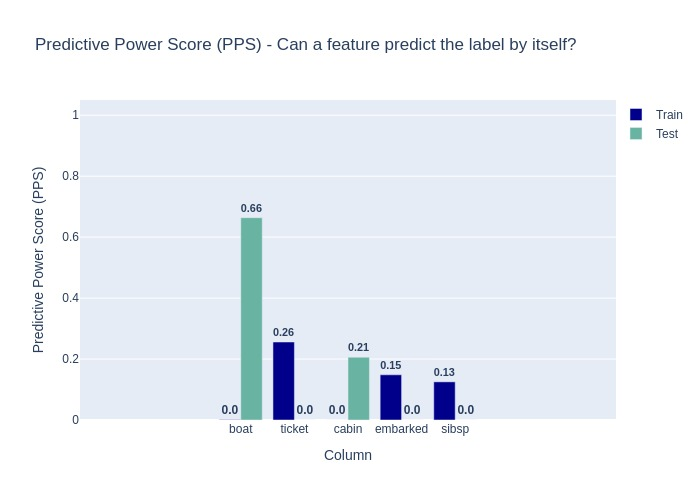

Status,Condition,More Info
✖,categorical drift score < 0.2 and numerical drift score < 0.2,Failed for 1 out of 8 columns. Found 1 numeric columns with Kolmogorov-Smirnov above threshold: {'body': '0.26'}


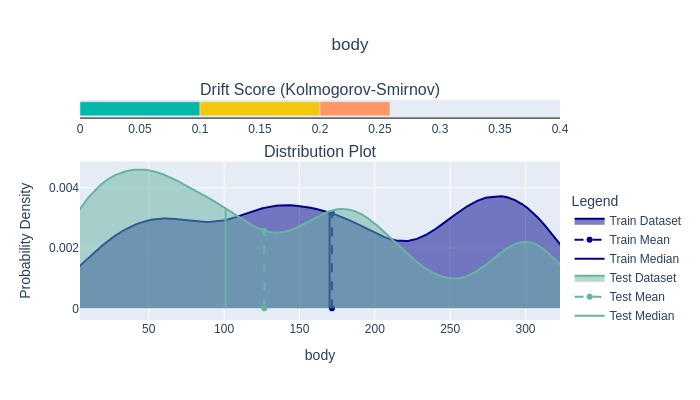

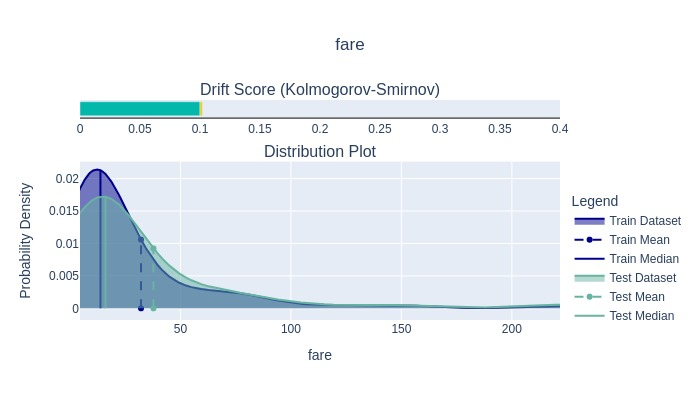

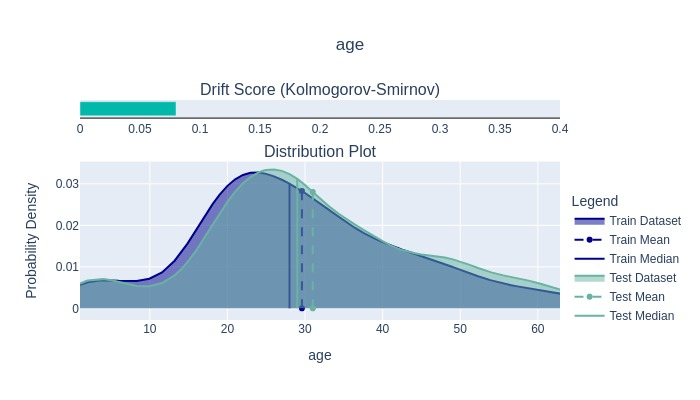

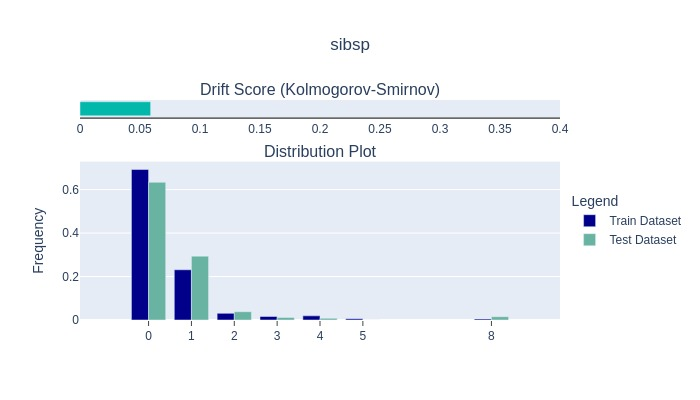

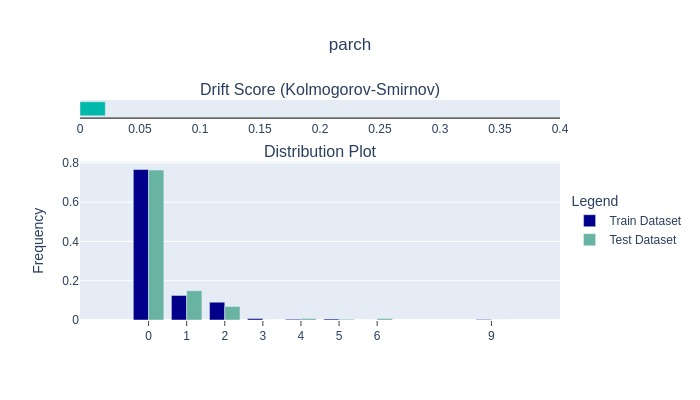

Status,Condition,More Info
✓,Test-Train size ratio is greater than 0.01,Test-Train size ratio is 0.25


,Train,Test
Size,1047,262


Status,Condition,More Info
✓,Ratio of samples with a new category is less or equal to 0%,Passed for 3 relevant features


,# New Categories,Ratio of New Categories,New Categories Names
Feature Name,,,
pclass,0,0%,[]
embarked,0,0%,[]
sex,0,0%,[]


Status,Condition,More Info
✓,Label drift score < 0.15,Label's drift score Cramer's V is 0


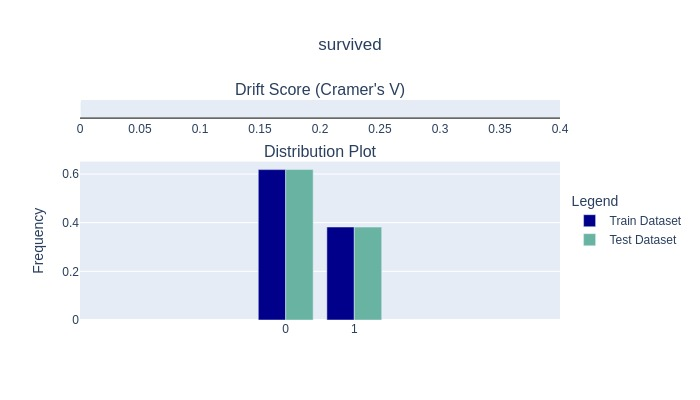

Status,Condition,More Info
✓,Drift value is less than 0.25,"Found drift value of: 0.09, corresponding to a domain classifier AUC of: 0.55"


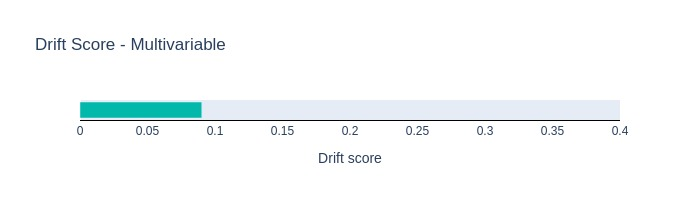

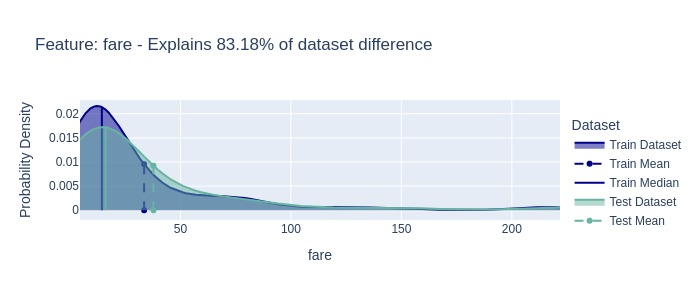

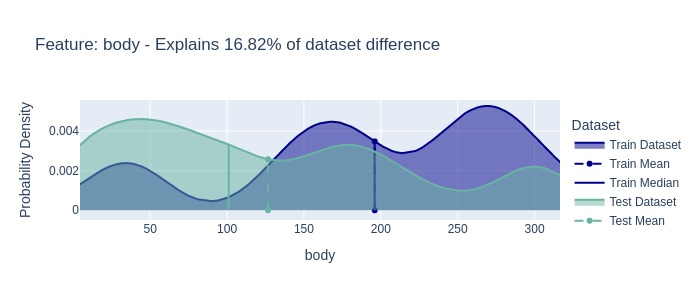

Check,Reason
Date Train Test Leakage Duplicates,DatasetValidationError: Dataset does not contain a datetime. see Dataset docs
Date Train Test Leakage Overlap,DatasetValidationError: Dataset does not contain a datetime. see Dataset docs
New Label Train Test,Nothing found
String Mismatch Comparison,Nothing found
Index Train-Test Leakage,Nothing found
Train Test Samples Mix,Nothing found


In [15]:
validation_suite = train_test_validation()
suite_result = validation_suite.run(train_ds, test_ds)
# Note: the result can be saved as html using suite_result.save_as_html()
# or exported to json using suite_result.to_json()
suite_result.show_not_interactive()

### Create pipeline

In [16]:
data_model_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestClassifier())]
)

## Hyperparameter tunning

Select the best hyperparameters for the models selected in the previous step.

### Random Forest

In [17]:
score = "recall"

hyperparameters = {
    "model__max_depth": [4, 5, 7, 9, 10],
    "model__max_features": [2, 3, 4, 5, 6, 7, 8, 9],
    "model__criterion": ["gini", "entropy"],
}


grid_search = RandomizedSearchCV(
    data_model_pipeline,
    hyperparameters,
    cv=5,
    scoring=score,
    n_jobs=8,
)
grid_search.fit(x_train, y_train);

In [18]:
grid_search.best_params_

{'model__max_features': 2, 'model__max_depth': 10, 'model__criterion': 'gini'}

In [19]:
best_data_model_pipeline = grid_search.best_estimator_
best_data_model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'fare', 'sibsp',
                                                   'parch']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'embarked']),
                                                 ('categoric ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['pclass'])])),
                ('model',
                 RandomForestClassifier(max_depth=10, max_features=2))])

### Evaluation

In [20]:
y_pred = best_data_model_pipeline.predict(x_test)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(f"recall: {recall}")
print(f"precision: {precision}")
print(f"f1: {f1}")
print(f"auc: {auc}")

recall: 0.75
precision: 0.78125
f1: 0.7653061224489796
auc: 0.8101851851851851


## Model Validation Suite

In [21]:
from deepchecks.tabular.suites import model_evaluation

evaluation_suite = model_evaluation()
suite_result = evaluation_suite.run(train_ds, test_ds, best_data_model_pipeline)
# Note: the result can be saved as html using suite_result.save_as_html()
# or exported to json using suite_result.to_json()
suite_result.show()


deepchecks - WARNING - Cannot use model's built-in feature importance on a Scikit-learn Pipeline, using permutation feature importance calculation instead
deepchecks - INFO - Calculating permutation feature importance. Expected to finish in 6 seconds


Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_4ELMK2AFCOQ09Z3H28S5HVA41">Model Evaluation S…

Status,Check,Condition,More Info
✖,Train Test Performance,Train-Test scores relative degradation is less than 0.1,3 scores failed. Found max degradation of 16.73% for metric Precision and class 1.
!,Weak Segments Performance - Test Dataset,The relative performance of weakest segment is greater than 80% of average model performance.,Found a segment with accuracy score of 0.5 in comparison to an average score of 0.824 in sampled data.
✓,ROC Report - Train Dataset,AUC score for all the classes is greater than 0.7,"All classes passed, minimum AUC found is 0.97 for class 1"
✓,ROC Report - Test Dataset,AUC score for all the classes is greater than 0.7,"All classes passed, minimum AUC found is 0.88 for class 1"
✓,Prediction Drift,Prediction drift score < 0.15,Found model prediction Kolmogorov-Smirnov drift score of 0.11
✓,Simple Model Comparison,Model performance gain over simple model is greater than 10%,"All classes passed, average gain for metrics: {'F1': '58.53%'}"
✓,Weak Segments Performance - Train Dataset,The relative performance of weakest segment is greater than 80% of average model performance.,Found a segment with accuracy score of 0.861 in comparison to an average score of 0.916 in sampled data.
✓,Unused Features - Train Dataset,Number of high variance unused features is less or equal to 5,Found 3 high variance unused features
✓,Unused Features - Test Dataset,Number of high variance unused features is less or equal to 5,Found 3 high variance unused features
✓,Model Inference Time - Train Dataset,Average model inference time for one sample is less than 0.001,Found average inference time (seconds): 1.473e-05


Status,Condition,More Info
✖,Train-Test scores relative degradation is less than 0.1,3 scores failed. Found max degradation of 16.73% for metric Precision and class 1.


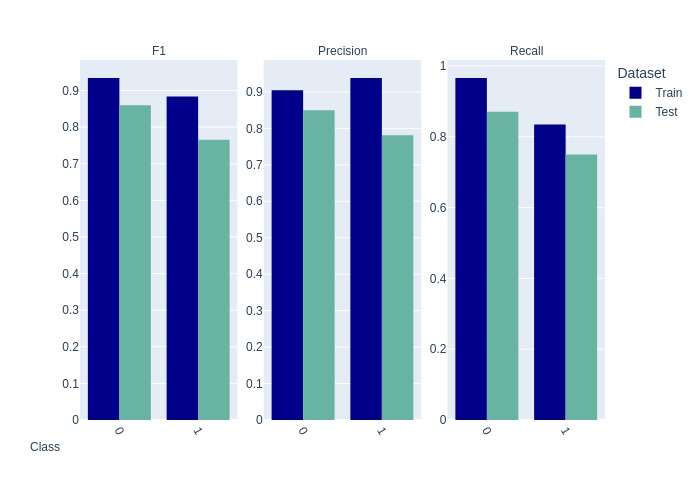

Status,Condition,More Info
!,The relative performance of weakest segment is greater than 80% of average model performance.,Found a segment with accuracy score of 0.5 in comparison to an average score of 0.824 in sampled data.


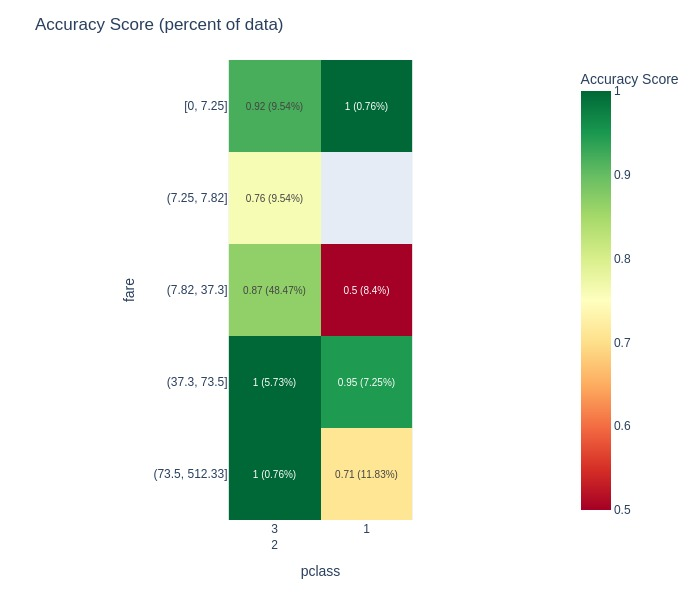

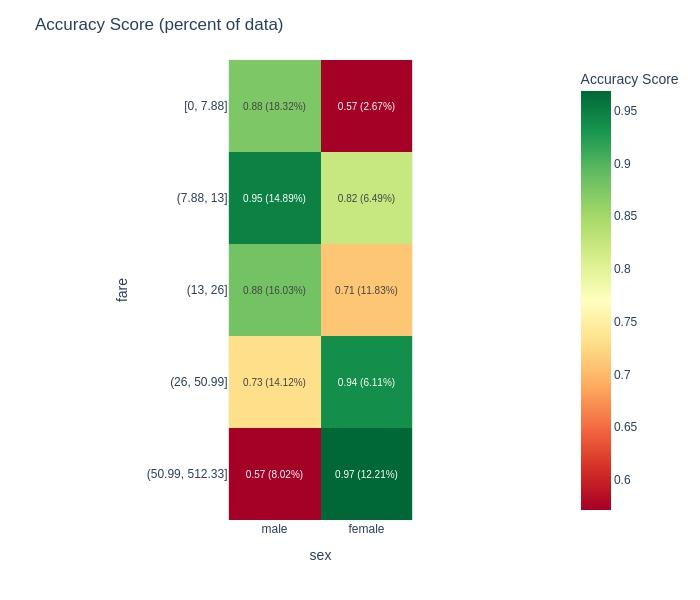

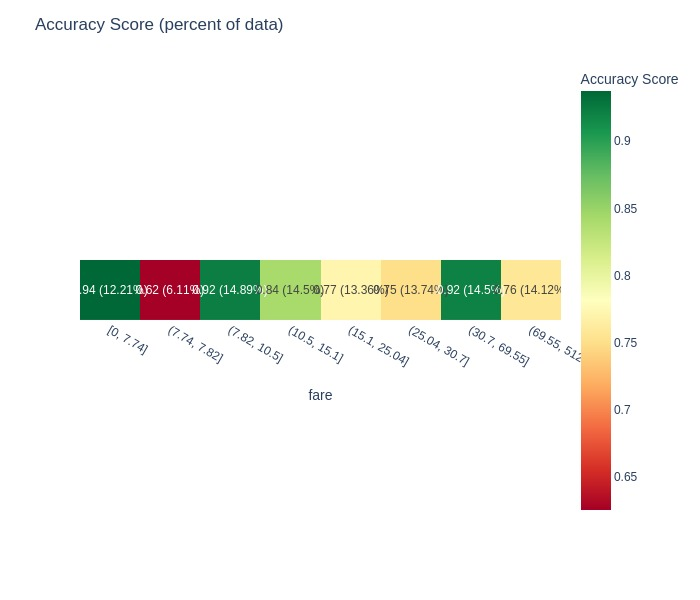

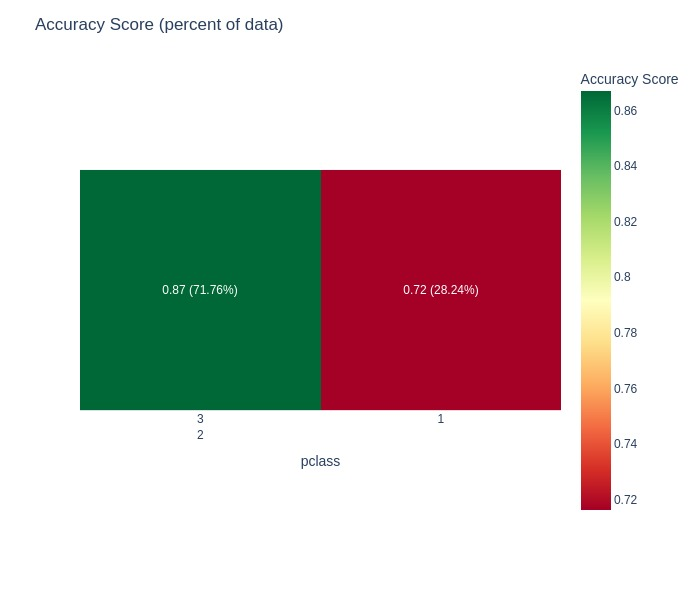

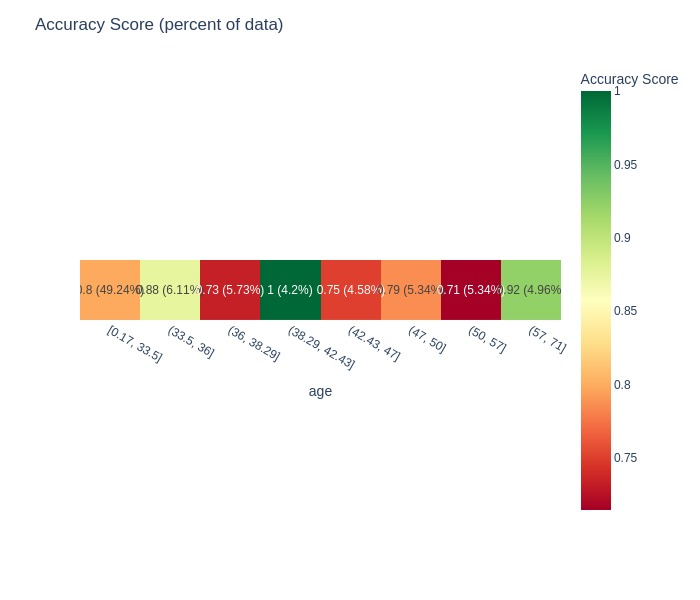

Status,Condition,More Info
✓,AUC score for all the classes is greater than 0.7,"All classes passed, minimum AUC found is 0.97 for class 1"


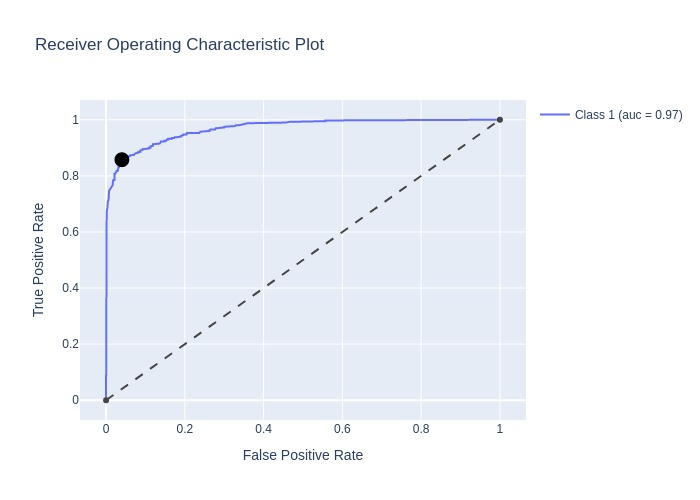

Status,Condition,More Info
✓,AUC score for all the classes is greater than 0.7,"All classes passed, minimum AUC found is 0.88 for class 1"


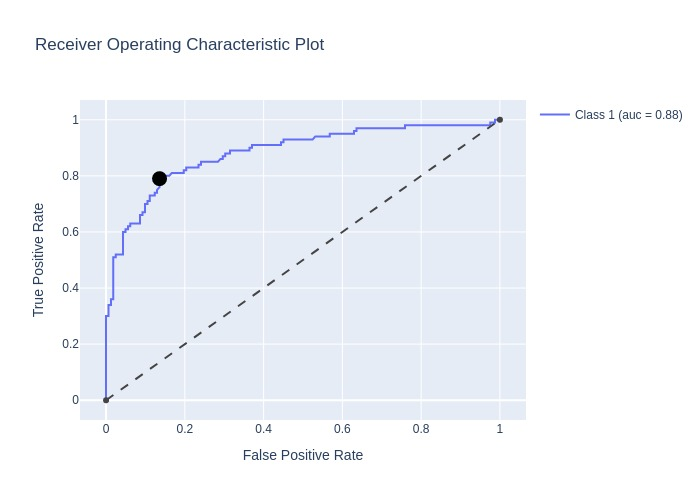

Status,Condition,More Info
✓,Prediction drift score < 0.15,Found model prediction Kolmogorov-Smirnov drift score of 0.11


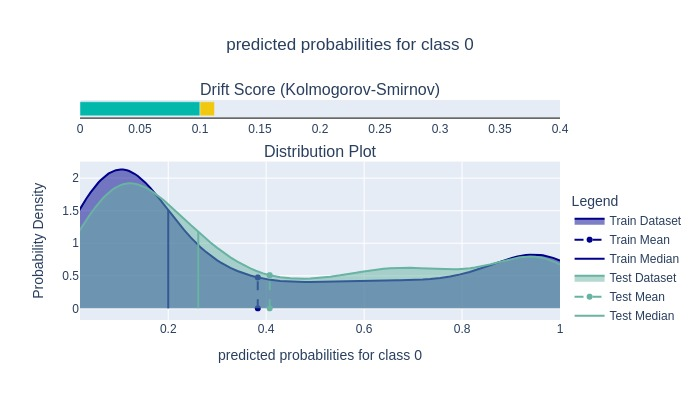

Status,Condition,More Info
✓,Model performance gain over simple model is greater than 10%,"All classes passed, average gain for metrics: {'F1': '58.53%'}"


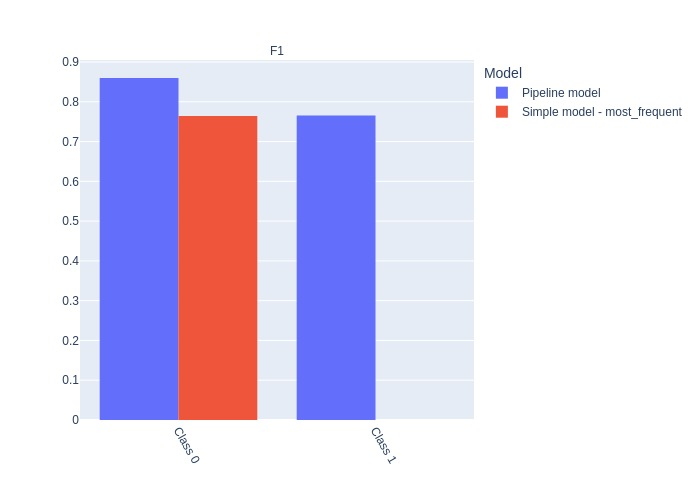

Status,Condition,More Info
✓,The relative performance of weakest segment is greater than 80% of average model performance.,Found a segment with accuracy score of 0.861 in comparison to an average score of 0.916 in sampled data.


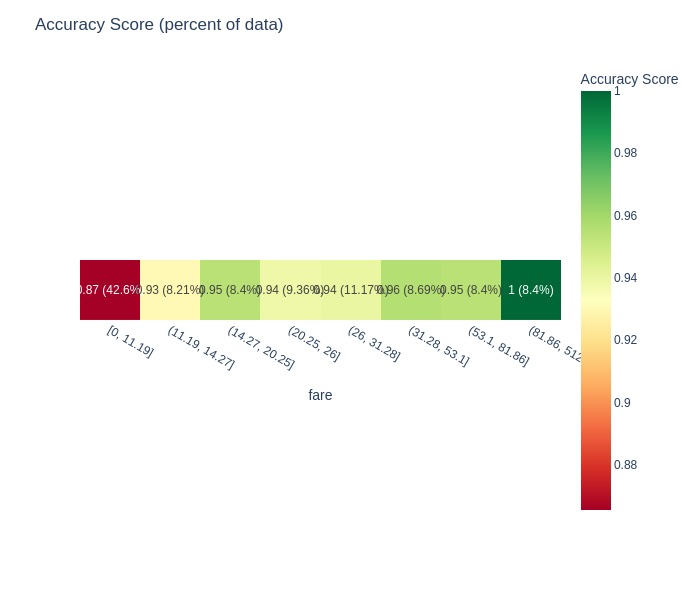

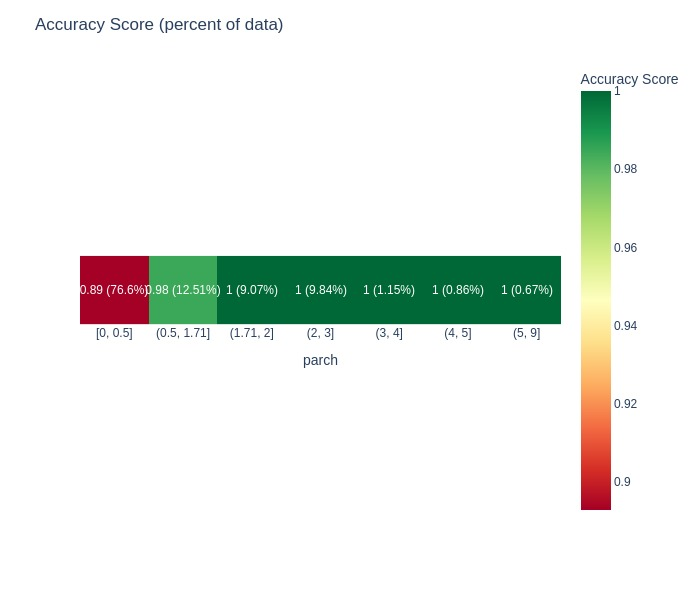

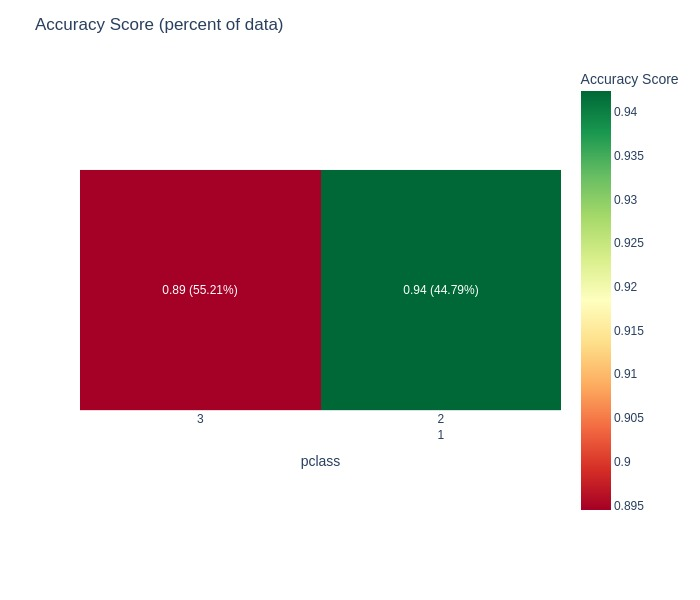

Status,Condition,More Info
✓,Number of high variance unused features is less or equal to 5,Found 3 high variance unused features


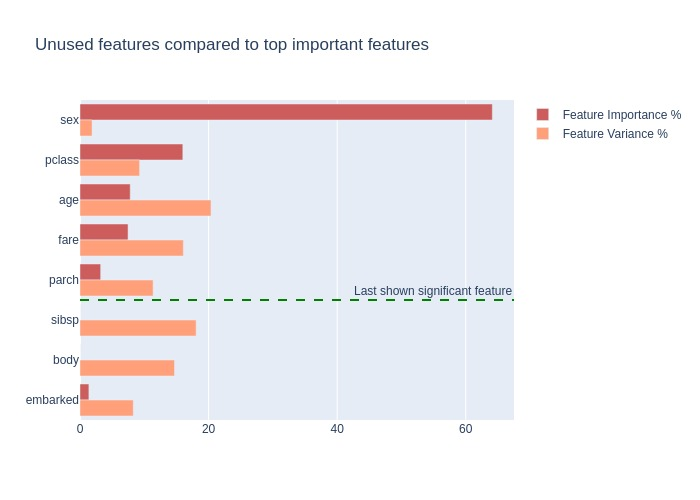

Status,Condition,More Info
✓,Number of high variance unused features is less or equal to 5,Found 3 high variance unused features


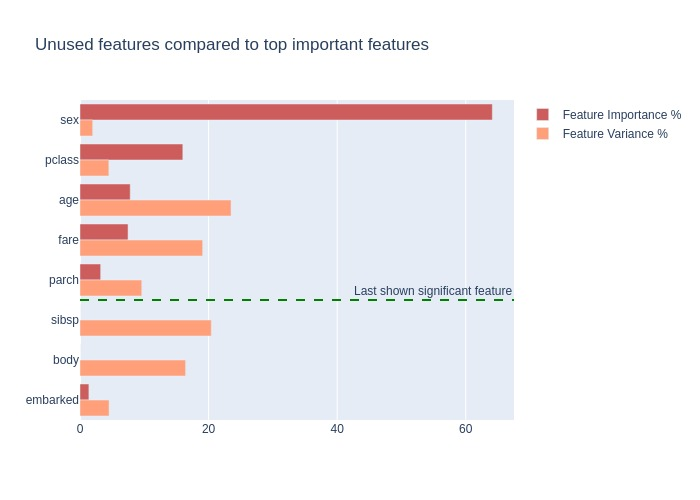

Status,Condition,More Info
✓,Average model inference time for one sample is less than 0.001,Found average inference time (seconds): 1.473e-05


Status,Condition,More Info
✓,Average model inference time for one sample is less than 0.001,Found average inference time (seconds): 3.98e-05


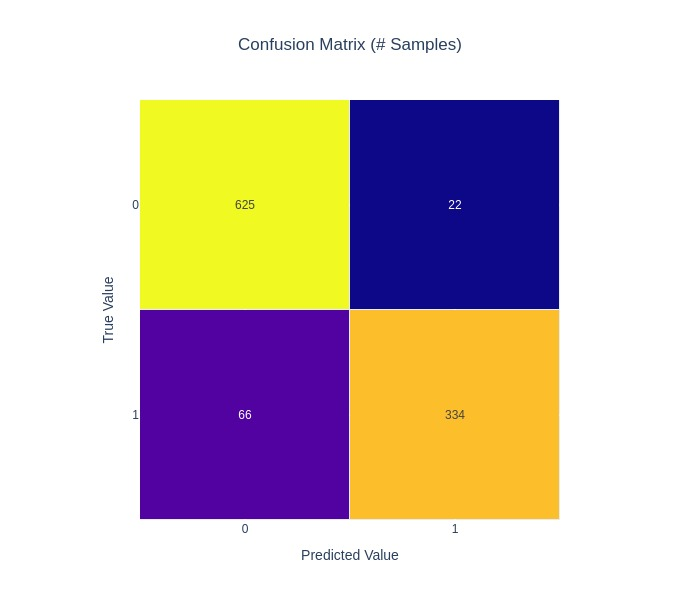

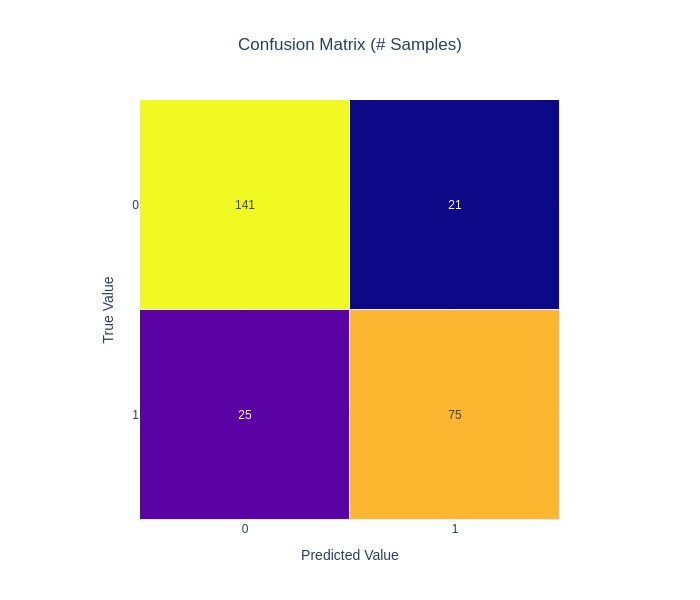

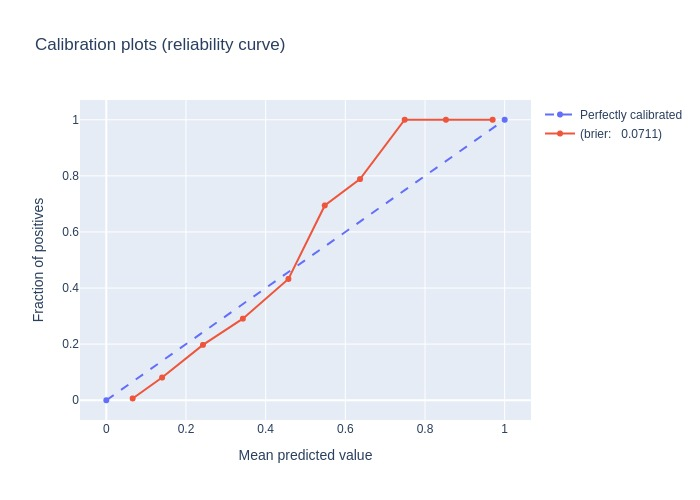

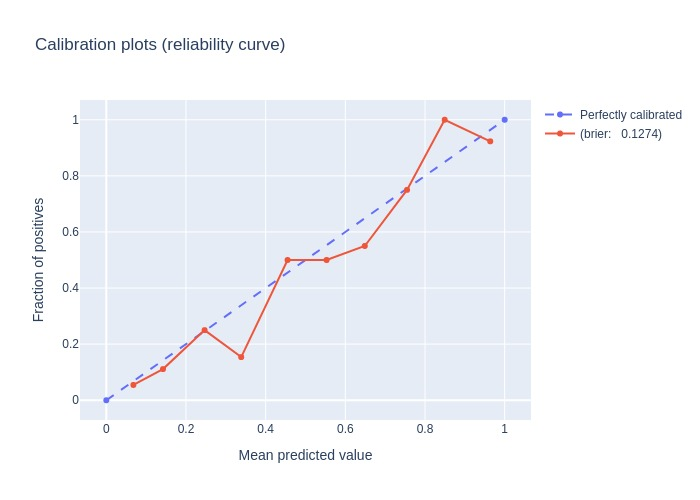

Check,Reason
Regression Error Distribution - Train Dataset,Check is irrelevant for classification tasks
Regression Error Distribution - Test Dataset,Check is irrelevant for classification tasks
Boosting Overfit,"Check is relevant for Boosting models of type ('AdaBoostClassifier', 'GradientBoostingClassifier', 'LGBMClassifier', 'XGBClassifier', 'CatBoostClassifier', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'LGBMRegressor', 'XGBRegressor', 'CatBoostRegressor'), but received model of type RandomForestClassifier"


In [22]:
suite_result.show_not_interactive()

## Save the model

In [23]:
DATA_MODEL = Path.cwd().resolve().parents[1] / "models"

In [ ]:
# Save the model with joblib
dump(
    best_data_model_pipeline,
    DATA_MODEL / "model.joblib",
    protocol=5,
)

## 📖 References

- <https://docs.deepchecks.com/stable/tabular/auto_tutorials/quickstarts/plot_quick_data_integrity.html>
- <https://docs.deepchecks.com/stable/tabular/auto_tutorials/quickstarts/plot_quick_train_test_validation.html>
- <https://docs.deepchecks.com/stable/tabular/auto_tutorials/quickstarts/plot_quick_model_evaluation.html>
- <https://joserzapata.github.io/courses/python-ciencia-datos/ml/>
- <https://joserzapata.github.io/courses/python-ciencia-datos/clasificacion/>
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edition - Aurélien Géron
- <https://joserzapata.github.io/post/lista-proyecto-machine-learning/>